<h1 style="color:orange;text-align:center;font-family:courier;font-size:280%">Text Classification From Scratch Using Transformers</h1>
<p style="color:orange;text-align:center;font-family:courier"> The objective is to understand how to customize and build a transformer model from scratch and customizing it for text classification task.</p>

### Objectives 
* Understand the theory and building blocks of NLP(Natural Language Processing Pipeline.
* Generate a basic understanding of how to use Tensorflow Keras API for creating custom utilities.
* Simplify the pedagogy of explaining NLP topics.
* As an example we will use **Genre Classification** Dataset for the task containing 16 labels.
<!-- * Though the code works there are significant drawbacks with yolov1 which has been addressed on YoloV2,YoloV3 -->


<p style="text-align:center"><img src="assets/movies.jpg" alt="textcla" width="540"/>

### Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import re
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy.special import softmax
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

### Importing Dataset and Applying pre-processing 
**Steps :**
* Read the csv file 
* Overview of the process:
  * Transform Text Information to Numerical Representation using **Text Vectorization** Layer.
  * Transform Target Variable to Numerical encoding using **Lable Encoder**.
  
#### Reading CSV file and selecting required columns.

In [2]:
dataset = pd.read_csv("movie_genre_dataset.csv")
dataset.dropna(axis=0,inplace=True)
dataset.reset_index(drop=True,inplace=True)
dataset = dataset[["genre","plot"]]

#### Encoder Target Columns and extract some informations for "Text Vectorizer" Layer

In [3]:
genre_Encoder = LabelEncoder()
dataset["genre"] = genre_Encoder.fit_transform(dataset["genre"])
sentence_lengths =[len(list(set(dataset["plot"][i].split()))) for i in range(dataset.shape[0])]
MAX_SEQ_LENGTH = int(np.mean(sentence_lengths))
MAX_TOKENS = sum(sentence_lengths)

#### Create a Text Vectorizer Layer and use Adapt method to Adapt to our dataset

In [4]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKENS,output_mode="int",
                               output_sequence_length=MAX_SEQ_LENGTH)
vectorizer.adapt(dataset["plot"])

#### Create train test splits 

In [5]:
index = int(dataset.shape[0]*0.30)

train_set =dataset.iloc[index:,:]
test_set = dataset.iloc[-index:,:]

X_train_set = tf.cast(vectorizer(train_set["plot"]),tf.int32)
X_test_set =  tf.cast(vectorizer(test_set["plot"]),tf.int32)
Y_train_set = tf.cast(train_set["genre"],tf.int32)
Y_test_set = tf.cast(test_set["genre"],tf.int32)

CLASSES=np.unique(Y_train_set).shape[0]


#### Build Dataset Pipeline

In [6]:
BATCH_SIZE=12
VOCAB = vectorizer.vocabulary_size()
EMBEDDING_SIZE= 256
DENSE_DIM=512
TRANSFORMER_HEADS = 4

auto = tf.data.AUTOTUNE
train_set = tf.data.Dataset.from_tensor_slices((X_train_set,Y_train_set))
train_set = train_set.batch(BATCH_SIZE,drop_remainder=True).shuffle(2000).prefetch(auto).cache()

test_set = tf.data.Dataset.from_tensor_slices((X_test_set,Y_test_set))
test_set = test_set.batch(BATCH_SIZE).shuffle(2000)

train_steps = X_train_set.shape[0]//BATCH_SIZE
val_steps = X_test_set.shape[0]//BATCH_SIZE

### Building Model Pipeline

### Building Classification Pipeline using Transformers is straightforward containing only two steps:
   * Building Input Layer 
   * Building Embedding and Positional Encoding Layers.
   * Building Transformers Multi headed Attention Layer.
   * Building Classification Heads.
  
  
### Building Positional Encoding Layer



* why we need postional encoding?<br>
  **Note :  Positional Encoding Can be ignored if text sequence meaning doesn't matter.**
  <br>
    Positinal Encoding Helps to Add positinal Information in our representation. By default when we train a RNN model for classification
    tasks the RNN carries the positonal information naturally. RNN's are simply acts like a for loop, with every current context depends on the
    previous context.
    
    * BELOW IS AN RNN EXAMPLE:
    <p style="text-align:center"><img src="assets/RNN.png" alt="textcla" width="340"/><br>
    <br>

* We can use 1D Convolution for classification tasks which cannot carry Positional Information like RNN. But in our experiment we will exploit a Transformer based architecture which will keep positional context, for this design we will need to use positional encoding information added to our sequence.

* How to create positional Encoding?
    * simply adding a sequence of [1,2,3] to our embedding vector can form positional information which is called **Absolute Encoding** but we will implement a Positional Encoding layer defined in the paper <a href="https://arxiv.org/abs/1706.03762">Attention is all you need</a> which is a relative form of encoding introduced by the authors.
    * BELOW IS AN POSITIONAL ENCODE EXAMPLE FROM THE PAPER:
    <p style="text-align:center"><img src="assets/pos.jpg" alt="textcla" width="540"/><br>
    <br>

In [12]:
class Postional_Encoding(tf.keras.layers.Layer):
    def __init__(self,embedding_depth,vocab,sequence_length):
        super(Postional_Encoding,self).__init__()
        self.embedding_depth = embedding_depth
        self.sequence_length = sequence_length
        self.embed = tf.keras.layers.Embedding(vocab,embedding_depth)
        
    def call(self,data):
        batch_dim = tf.shape(data)[0]
        embeds = np.arange(self.embedding_depth)[np.newaxis,:]
        embeds = 1 / np.power(10000, (2 * (embeds//2)) / np.float32(self.embedding_depth))
        location_id = np.arange(self.sequence_length)[:,np.newaxis]
        pos = embeds*location_id
        pos[:,::2] = np.sin(pos[:,::2])
        pos[:,1::2] = np.cos(pos[:,1::2])
        pos = tf.tile(pos[tf.newaxis,:,:],(batch_dim,1,1))
        pos = tf.cast(pos,tf.float32)
        embed = self.embed(data)
        return embed+pos 

    def compute_mask(self,data,mask=None):
        return tf.not_equal(0,data)

### Implementing Transformer Layer
In general in the paper **Attention is all you need** They have implemented and Encoder and Decoder considering a text to text sequence task like chatbot, machine translation but in our task of classification we don't need a decoder part, we will just use encoder and build a custom classification head on top of it

 <p style="text-align:center"><img src="assets/multihead.png" alt="textcla" width="240"/><br>
    <br>
    
#### Key aspects of the Transformer layer design:
* Utilize Multi-Headed Attention.
* Make the layer as a mask consumer just by adding ```self.support_masking``` flag, The reason behind it is we want zeros to be masked and not included in any computation since they are just a dummy padded values.
* Note : Mask consumer can automatically detect masks if the previous layer produces it .In our case positional encoding layer can produce it.


In [13]:
class Transformer_Encoder(tf.keras.layers.Layer):
    def __init__(self,embedding_depth,dense_dim,heads=2,**kwargs):
        super(Transformer_Encoder,self).__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=heads,key_dim=embedding_depth)
        self.dense_proj = tf.keras.Sequential([tf.keras.layers.Dense(dense_dim, activation="relu"), 
                                               tf.keras.layers.Dense(embedding_depth),])
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True
        
    def call(self,x,mask=None):
        padding_mask = tf.cast(mask,tf.int64)[:,:,tf.newaxis]
        attention_out = self.attention(x,x,x,attention_mask=padding_mask)
        layernorm1 = self.layernorm_1(attention_out+x)
        denseproj  = self.dense_proj(layernorm1)
        layernorm2 = self.layernorm_2(denseproj+layernorm1)
        return layernorm2

### Connecting all the pieces in a single model
<p style="text-align:center"><img src="assets/chain.png" alt="textcla" width="240"/><br>
<br>

In [9]:
class Text_Classifier(tf.keras.models.Model):
    def __init__(self,embedding_depth,vocab,seq_length,
                 dense_depth,transformer_heads=2,labels=10):
        super(Text_Classifier,self).__init__()
        self.poslayer = Postional_Encoding(embedding_depth,vocab,seq_length)
        self.transformer = Transformer_Encoder(embedding_depth,dense_depth,heads=transformer_heads)
        self.classifier_head = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling1D(),
                                   tf.keras.layers.Dense(labels,activation="softmax")])

    def call(self,x):
        x = self.poslayer(x)
        x = self.transformer(x)
        x = self.classifier_head(x)
        return x

### Building, Compiling and Training 

In [10]:
custom_classifier = Text_Classifier(embedding_depth=EMBEDDING_SIZE,vocab=VOCAB,
                         seq_length=MAX_SEQ_LENGTH,dense_depth=DENSE_DIM,
                         transformer_heads=TRANSFORMER_HEADS,
                         labels=CLASSES)
custom_classifier.compile(optimizer="Nadam",loss="sparse_categorical_crossentropy",metrics=["acc"])
ckpt = ModelCheckpoint("genre_Weights/classifier",save_best_only=True,save_weights_only=True,monitor='val_loss',mode='min')

history=custom_classifier.fit(train_set,batch_size=BATCH_SIZE,validation_data=test_set,
           steps_per_epoch=train_steps,validation_steps=val_steps,epochs=15,callbacks=[ckpt])

Epoch 1/15
2195/2195 [==============================] - 27s 11ms/step - loss: 2.1037 - acc: 0.3054 - val_loss: 1.8035 - val_acc: 0.3857
Epoch 2/15
2195/2195 [==============================] - 24s 11ms/step - loss: 1.7177 - acc: 0.4355 - val_loss: 1.5281 - val_acc: 0.5124
Epoch 3/15
2195/2195 [==============================] - 24s 11ms/step - loss: 1.4472 - acc: 0.5324 - val_loss: 1.2547 - val_acc: 0.6142
Epoch 4/15
2195/2195 [==============================] - 24s 11ms/step - loss: 1.1910 - acc: 0.6216 - val_loss: 1.0372 - val_acc: 0.6742
Epoch 5/15
2195/2195 [==============================] - 25s 11ms/step - loss: 0.9625 - acc: 0.6945 - val_loss: 0.8724 - val_acc: 0.7226
Epoch 6/15
2195/2195 [==============================] - 25s 11ms/step - loss: 0.7619 - acc: 0.7573 - val_loss: 0.7058 - val_acc: 0.7725
Epoch 7/15
2195/2195 [==============================] - 25s 11ms/step - loss: 0.6123 - acc: 0.8068 - val_loss: 0.6068 - val_acc: 0.7983
Epoch 8/15
2195/2195 [==========================

### Model Logs and Performance Interpretation
* We will use F1 score as a metric to evaluate classification performance

F1 score of the model : 0.9220937568044737


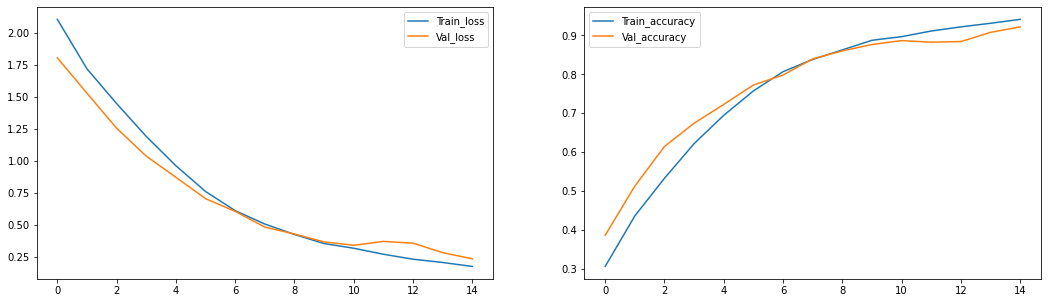

In [11]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].plot(history.history["loss"],label="Train_loss")
ax[0].plot(history.history["val_loss"],label="Val_loss")
ax[0].legend()

ax[1].plot(history.history["acc"],label="Train_accuracy")
ax[1].plot(history.history["val_acc"],label="Val_accuracy")
ax[1].legend()

# predict on validation set
predictions = tf.argmax(custom_classifier.predict(X_test_set),axis=1)
F1_SCORE = f1_score(Y_test_set.numpy(),predictions.numpy(),average='weighted')

print(f"F1 score of the model : {F1_SCORE}")